# Descripción paso-a-paso del Taller 1
El archivo donde se encuentra el dataset está en __[este enlace](http://www.dtic.upf.edu/~ocelma/MusicRecommendationDataset/lastfm-1K.html)__.<br />
Importo las librerías que se usarán en el taller.

In [3]:
import pandas as pd, numpy as np, time, os
from IPython.display import display
import matplotlib.pyplot as plt
from surprise import Dataset, Reader, SVD, NormalPredictor
from surprise.model_selection import cross_validate

En la primera ejecución debo cargar el dataset _**userid-timestamp-artid-artname-traid-traname.tsv**_ original. Este proceso es lento; sin embargo puedo generar un _Pickle_ al terminar de cargarlo para que en las ejecuciones posteriores pueda usar el _Pickle_ con el _Dataframe_ serializado en lugar del archivo original. Empíricamente esto agiliza más de 10 veces el cargue!

In [3]:
def cargar_archivo(archivo, pickle, columnas, fechas, sep = '\t'):

    try:

        t1 = time.clock()
        print('Cargando el pickle (si existe)...')
        tabla = pd.read_pickle(pickle)
        t2 = time.clock()
        print('Leer la tabla DATASET toma {:.2f} segundos'.format(t2 - t1))

    except FileNotFoundError:
        
        print('El Pickle NO existe. Creando el Pickle...')
        t1 = time.clock()
        tabla = pd.read_csv(archivo, sep = sep, names = columnas, parse_dates = fechas)
        t2 = time.clock()

        print('Leer la tabla toma {:.2f} segundos'.format(t2 - t1))

        tabla.to_pickle(pickle)

    return tabla

def cargar_dataset():
    fechas = ['TIMESTAMP']
    archivo = os.path.join('lastfm-dataset-1K', 'userid-timestamp-artid-artname-traid-traname.tsv')
    pickle = 'dataset.pickle'
    columnas = ['USERID', 'TIMESTAMP', 'ARTIST_ID', 'ARTIST_NAME', 'TRACK_ID', 'TRACK_NAME']
    return cargar_archivo(archivo, pickle, columnas, fechas)

Cargue del dataset (cuando no existe el _Pickle_, toma cerca de tres minutos; cuando sí existe, toma cerca de 12 segundos):

In [4]:
dataset = cargar_dataset()
dataset['VALOR'] = 1

Cargando el pickle (si existe)...
Leer la tabla DATASET toma 16.02 segundos


Muestro las primeras 10 columnas del _Dataframe_ para hacerme una mejor idea de los datos

In [4]:
display(dataset.head(10))

,USERID,TIMESTAMP,ARTIST_ID,ARTIST_NAME,TRACK_ID,TRACK_NAME,VALOR
0,user_000001,2009-05-04 23:08:57,f1b1cf71-bd35-4e99-8624-24a6e15f133a,Deep Dish,NaN,Fuck Me Im Famous (Pacha Ibiza)-09-28-2007,1
1,user_000001,2009-05-04 13:54:10,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,NaN,Composition 0919 (Live_2009_4_15),1
2,user_000001,2009-05-04 13:52:04,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,NaN,Mc2 (Live_2009_4_15),1
3,user_000001,2009-05-04 13:42:52,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,NaN,Hibari (Live_2009_4_15),1
4,user_000001,2009-05-04 13:42:11,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,NaN,Mc1 (Live_2009_4_15),1
5,user_000001,2009-05-04 13:38:31,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,NaN,To Stanford (Live_2009_4_15),1
6,user_000001,2009-05-04 13:33:28,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,NaN,Improvisation (Live_2009_4_15),1
7,user_000001,2009-05-04 13:23:45,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,NaN,Glacier (Live_2009_4_15),1
8,user_000001,2009-05-04 13:19:22,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,NaN,Parolibre (Live_2009_4_15),1
9,user_000001,2009-05-04 13:13:38,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,NaN,Bibo No Aozora (Live_2009_4_15),1


_"Describo"_ el dataset de eventos

In [20]:
dataset.describe()

,VALOR
count,19098862.0
mean,1.0
std,0.0
min,1.0
25%,1.0
50%,1.0
75%,1.0
max,1.0


Identifico cuántos artistas no tienen ARTIST_ID y elimino todos esos registros del dataset. Eso lo hago para reducir la dimensionalidad.

In [29]:
print('CANCIONES DE ARTISTAS SIN ARTIST_ID: {}'.format(dataset['ARTIST_ID'].isnull().sum()))
dataset = dataset[dataset.ARTIST_ID.notnull()]
dataset.describe()

CANCIONES DE ARTISTAS SIN ARTIST_ID: 600853


,VALOR
count,18498009.0
mean,1.0
std,0.0
min,1.0
25%,1.0
50%,1.0
75%,1.0
max,1.0


Transformo el listado de usuarios y artistas en una matriz con usuarios en las filas y artistas en las columnas. El valor de la intersección usuario - artista es la cantidad de veces que el artista ha escuchado canciones del artista

In [30]:
try:

    t1 = time.clock()
    print('Cargando el pickle (si existe)...')
    dataset_2 = pd.read_pickle('matriz.pickle')
    t2 = time.clock()
    print('Leer la tabla DATASET toma {:.2f} segundos'.format(t2 - t1))

except FileNotFoundError:

    print('El Pickle NO existe. Creando el Pickle...')
    t1 = time.clock()
    dataset_2 = dataset[['USERID', 'ARTIST_NAME', 'VALOR']].pivot_table(index = 'USERID', columns = 'ARTIST_NAME', aggfunc = np.sum, fill_value = 0)
    t2 = time.clock()

    print('Leer la tabla toma {:.2f} segundos'.format(t2 - t1))

    dataset_2.to_pickle('matriz.pickle')

#dataset[['USERID', 'ARTIST_NAME', 'VALOR']].pivot_table(index = 'USERID', columns = 'ARTIST_NAME', aggfunc = lambda x: len(x.unique()), fill_value = 0)
display(dataset_2)

Cargando el pickle (si existe)...
El Pickle NO existe. Creando el Pickle...
Leer la tabla toma 129.99 segundos


VALOR                                                        \
ARTIST_NAME   !!! !Action Pact! !Cube !Deladap !T.O.O.H.! !Ved ##### #9   
USERID                                                                    
user_000001     0             0     0        0          0    0     0  0   
user_000002     0             0     0        3          0    0     0  0   
user_000003     0             0     0        0          0    0     0  0   
user_000004    48             0     0        0          0    0     0  0   
user_000005     0             0     0        0          0    0     0  0   
user_000006     0             0     0        0          0    0     1  0   
user_000007     0             0     0        0          0    0     0  0   
user_000008     0             0     0        0          0    0     0  0   
user_000009     0             0     0        0          0    0     0  0   
user_000010     0             0     0        0          0    0     0  0   
user_000011     0             0     0        0          0    0     0  0   
user_000012    90             0     0        0          0    0     0  0   
user_000013     0             0     0        0          0    0     0  0   
user_000014     0             0     0        0          0    0     0  0   
user_000015     0             0     0        0          0    0     0  0   
user_000016     0             0     0        0          0    0     0  0   
user_000017     0             0     0        0          0    0     0  0   
user_000018     0             0     0        0          0    0     0  0   
user_000019     0             0     0        0          0    0     0  0   
user_000020     0             0     0        0          0    0     0  0   
user_000021     0             0     0        0          0    0     0  0   
user_000022     0             0     0        0          0    0     0  0   
user_000023     0             0     0        0          0    0     0  0   
user_000024    24             0     0        0          0    0     0  0   
user_000025     0             0     0        0          0    0     0  0   
user_000026     0             0     0        0          0    0     0  0   
user_000027     0             0     0        0          0    0     0  0   
user_000028     0             0     0        0          0    0     0  0   
user_000029     0             0     0        0          0    0     0  0   
user_000030    42             0     0        0          0    0     0  0   
...           ...           ...   ...      ...        ...  ...   ... ..   
user_000970     0             0     0        0          0    0     0  0   
user_000971     0             0     0        0          0    0     0  0   
user_000972     0             0     0        0          0    0    32  0   
user_000973     0             0     0        0          0    0     0  0   
user_000974     9             0     0        0          0    0     0  0   
user_000975     1             0     0        0          0    0     0  0   
user_000976     0             0     0        0          0    0     0  0   
user_000977     0             0     0        0          0    0     0  0   
user_000978     0             0     0        0          0    0     0  0   
user_000979     0             0     0        0          0    0     0  0   
user_000980    11             0     0        0          0    0     0  0   
user_000981     0             0     0        0          0    0     0  0   
user_000982     0             0     0        0          0    0     0  0   
user_000983     6             0     0        0          0    0     0  0   
user_000984     0             0     0        0          0    0     0  0   
user_000985     0             0     0        0          0    0     0  0   
user_000986     0             0     0        0          0    0     0  0   
user_000987     0             0     0        0          0    0     0  0   
user_000989     0             0     0        0          0    0     0  0   
user_000990     0             0     0

Elimino todos los grupos que han sido escuchado por menos de 10 usuarios. Esto es la fase 2 de la reducción de dimensionalidad.

In [75]:
for col in dataset_2.columns.values:
    if dataset_2[dataset_2[col] != 0][col].count() < 10:
        dataset_2.drop(col, axis = 1, inplace = True)

El proceso sigue siendo muy lento. Elimino los grupos que hayan sido escuchados por menos de 100 usuarios.

In [263]:
#dataset_2 = pd.read_pickle('matriz_limpia.pickle')

for col in dataset_2.columns.values:
    if dataset_2[dataset_2[col] != 0][col].count() < 100:
        dataset_2.drop(col, axis = 1, inplace = True)

Guardo el resultado en un Pickle para no tener que volver a ejecutar la reducción de dimensionalidad, ya que toma un montón de tiempo!

In [264]:
dataset_2.to_pickle('matriz_limpia_v2.pickle')

In [265]:
dataset_2.describe()

VALOR                                               \
ARTIST_NAME          !!! ...And You Will Know Us By The Trail Of Dead   
count         992.000000                                   992.000000   
mean            5.941532                                     7.583669   
std            46.423451                                    50.180995   
min             0.000000                                     0.000000   
25%             0.000000                                     0.000000   
50%             0.000000                                     0.000000   
75%             0.000000                                     0.000000   
max          1292.000000                                  1134.000000   

                                                                      \
ARTIST_NAME        10Cc         2Pac 3 Doors Down 30 Seconds To Mars   
count        992.000000   992.000000   992.000000         992.000000   
mean           1.419355     6.900202     6.535282          10.119960   
std           12.383200    57.752430    39.222396          64.984969   
min            0.000000     0.000000     0.000000           0.000000   
25%            0.000000     0.000000     0.000000           0.000000   
50%            0.000000     0.000000     0.000000           0.000000   
75%            0.000000     0.000000     0.000000           0.000000   
max          292.000000  1342.000000   601.000000        1324.000000   

                                                                 \
ARTIST_NAME         311       4Hero      50 Cent 65Daysofstatic   
count        992.000000  992.000000   992.000000     992.000000   
mean           3.675403    1.324597     4.922379       6.903226   
std           31.341701    9.057250    38.976552      51.374063   
min            0.000000    0.000000     0.000000       0.000000   
25%            0.000000    0.000000     0.000000       0.000000   
50%            0.000000    0.000000     0.000000       0.000000   
75%            0.000000    0.000000     0.000000       0.000000   
max          686.000000  146.000000  1066.000000    1101.000000   

                     ...                                                \
ARTIST_NAME          ...            Yonderboi       Zero 7  Zoot Woman   
count                ...           992.000000   992.000000  992.000000   
mean                 ...             1.512097    17.786290    1.489919   
std                  ...            12.834814    79.153204   10.810070   
min                  ...             0.000000     0.000000    0.000000   
25%                  ...             0.000000     0.000000    0.000000   
50%                  ...             0.000000     0.000000    0.000000   
75%                  ...             0.000000     4.000000    0.000000   
max                  ...           272.000000  1094.000000  228.000000   

                                                                           \
ARTIST_NAME        Zwan       Zz Top [Television Theme Songs]   [Unknown]   
count        992.000000   992.000000               992.000000  992.000000   
mean           1.910282     7.658266                 1.445565    8.269153   
std           22.200786   101.214866                11.367144   28.518607   
min            0.000000     0.000000                 0.000000    0.000000   
25%            0.000000     0.000000                 0.000000    0.000000   
50%            0.000000     0.000000                 0.000000    0.000000   
75%            0.000000     0.000000                 0.000000    3.000000   
max          648.000000  2875.000000               237.000000  323.000000   

                                                            
ARTIST_NAME  Édith Piaf Émilie Simon Пётр Ильич Чайковский  
count        992.000000   992.000000            992.000000  
mean           2.212702     3.039315              1.214718  
std           13.007571    24.422564              7.056444  
min            0.000000     0.000000              0.000000  
25%            0.0

Ahora debo convertir el número de visualizaciones en un rango *0 .. 5*. Esto lo hago con una distribución acumulativa complementaria. Primero observo los primeros 50 artistas en términos de la máxima cantidad de reproducciones por usuario:

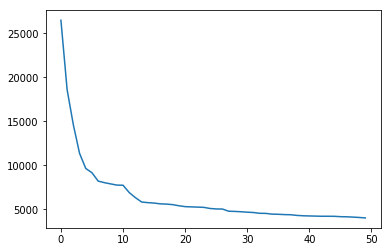

In [266]:
x = np.arange(0, 50, 1)
y_raw = dataset_2.max(axis = 0).astype('float64').sort_values(ascending = False)
y = y_raw[0:50]
plt.plot(x, y)
plt.show()

Luego convierto los valores numéricos a un rango 0..5. De [1, 0.8) es 5, de [0.8, 0.6) es 4, etc. hasta [0.2, 0] que es 0

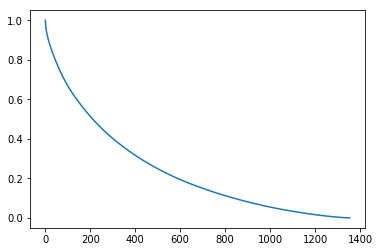

In [273]:
suma_i = 0
y_raw = dataset_2.max(axis = 0).astype('float64').sort_values(ascending = True)
suma = sum(y_raw)

for i in y_raw.axes[0]:
    suma_i += y_raw[i] / suma
    y_raw[i] = suma_i

y_raw = y_raw.sort_values(ascending = False)
x = np.arange(0, 1355, 1)
y = y_raw[0:1355]
plt.plot(x, y)
plt.show()

In [274]:
rango_5 = ''
rango_4 = ''
rango_3 = ''
rango_2 = ''
rango_1 = ''
r5 = 0
r4 = 0
r3 = 0
r2 = 0
r1 = 0
for i in y_raw.axes[0]:
    if y_raw[i] > 0.8:
        rango_5 = i
    elif y_raw[i] > 0.6:
        rango_4 = i
    elif y_raw[i] > 0.4:
        rango_3 = i
    elif y_raw[i] > 0.2:
        rango_2 = i
    elif y_raw[i] > 0.0:
        rango_1 = i
r5 = dataset_2[rango_5].max(axis = 0)
r4 = dataset_2[rango_4].max(axis = 0)
r3 = dataset_2[rango_3].max(axis = 0)
r2 = dataset_2[rango_2].max(axis = 0)
r1 = dataset_2[rango_1].max(axis = 0)
print('Limite para el rating 5: {} con {}'.format(rango_5, r5))
print('Limite para el rating 4: {} con {}'.format(rango_4, r4))
print('Limite para el rating 3: {} con {}'.format(rango_3, r3))
print('Limite para el rating 2: {} con {}'.format(rango_2, r2))
print('Limite para el rating 1: {} con {}'.format(rango_1, r1))

Limite para el rating 5: ('VALOR', 'Tool') con 4215
Limite para el rating 4: ('VALOR', 'Thievery Corporation') con 2343
Limite para el rating 3: ('VALOR', 'Aesop Rock') con 1413
Limite para el rating 2: ('VALOR', 'Ferry Corsten') con 745
Limite para el rating 1: ('VALOR', 'Mc Hammer') con 36


In [20]:
try:

    t1 = time.clock()
    print('Cargando el pickle (si existe)...')
    dataset_3 = pd.read_pickle('matriz_limpia_y_estandarizada.pickle')
    t2 = time.clock()
    print('Leer la tabla matriz_limpia_y_estandarizada toma {:.2f} segundos'.format(t2 - t1))

except FileNotFoundError:

    print('El Pickle NO existe. Creando el Pickle matriz_limpia_y_estandarizada...')
    t1 = time.clock()
    dataset_3 = dataset_2.copy(deep = True)

    for i in dataset_3.columns:
        for j in enumerate(dataset_3[i]):
            if j[1] >= r5:
                dataset_3[i][j[0]] = 5
            elif j[1] >= r4:
                dataset_3[i][j[0]] = 4
            elif j[1] >= r3:
                dataset_3[i][j[0]] = 3
            elif j[1] >= r2:
                dataset_3[i][j[0]] = 2
            elif j[1] >= r1:
                dataset_3[i][j[0]] = 1
            else:
                dataset_3[i][j[0]] = 0
    t2 = time.clock()

    print('Leer la tabla toma {:.2f} segundos'.format(t2 - t1))

    dataset_3.to_pickle('matriz_limpia_y_estandarizada.pickle')

dataset_3.describe()

Cargando el pickle (si existe)...
Leer la tabla matriz_limpia_y_estandarizada toma 0.19 segundos


VALOR                                           \
ARTIST_NAME         !!! $Wingin' Utter$ 'Til Tuesday  (Həd) P.E.   
count        992.000000      992.000000   992.000000  992.000000   
mean           0.235887        0.018145     0.028226    0.039315   
std            0.443364        0.133544     0.165701    0.199562   
min            0.000000        0.000000     0.000000    0.000000   
25%            0.000000        0.000000     0.000000    0.000000   
50%            0.000000        0.000000     0.000000    0.000000   
75%            0.000000        0.000000     0.000000    0.000000   
max            4.000000        1.000000     1.000000    2.000000   

                                                                      \
ARTIST_NAME (We Are) Performance      *Nsync         +/-         +44   
count                 992.000000  992.000000  992.000000  992.000000   
mean                    0.012097    0.085685    0.048387    0.056452   
std                     0.109373    0.283621    0.219341    0.239489   
min                     0.000000    0.000000    0.000000    0.000000   
25%                     0.000000    0.000000    0.000000    0.000000   
50%                     0.000000    0.000000    0.000000    0.000000   
75%                     0.000000    0.000000    0.000000    0.000000   
max                     1.000000    2.000000    2.000000    2.000000   

                                          ...                              \
ARTIST_NAME         -M- ...And Oceans     ...           菅野よう子          谭盾   
count        992.000000    992.000000     ...      992.000000  992.000000   
mean           0.022177      0.010081     ...        0.085685    0.049395   
std            0.147335      0.099945     ...        0.335755    0.221406   
min            0.000000      0.000000     ...        0.000000    0.000000   
25%            0.000000      0.000000     ...        0.000000    0.000000   
50%            0.000000      0.000000     ...        0.000000    0.000000   
75%            0.000000      0.000000     ...        0.000000    0.000000   
max            1.000000      1.000000     ...        5.000000    2.000000   

                                                                         \
ARTIST_NAME        近藤浩治   雅-Miyavi-      電気グルーヴ        高木正勝        高橋洋子   
count        992.000000  992.000000  992.000000  992.000000  992.000000   
mean           0.037298    0.031250    0.019153    0.023185    0.012097   
std            0.199949    0.246123    0.137133    0.157127    0.109373   
min            0.000000    0.000000    0.000000    0.000000    0.000000   
25%            0.000000    0.000000    0.000000    0.000000    0.000000   
50%            0.000000    0.000000    0.000000    0.000000    0.000000   
75%            0.000000    0.000000    0.000000    0.000000    0.000000   
max            2.000000    5.000000    1.000000    2.000000    1.000000   

                                                 
ARTIST_NAME       鬼束ちひろ        鷺巣詩郎          鼓童  
count        992.000000  992.000000  992.000000  
mean           0.015121    0.028226    0.019153  
std            0.144782    0.165701    0.157670  
min            0.000000    0.000000    0.000000  
25%            0.000000    0.000000    0.000000  
50%            0.000000    0.000000    0.000000  
75%            0.000000    0.000000    0.000000  
max            3.000000    1.000000    3.000000  

[8 rows x 13758 columns]

Muestro la nueva matriz, que ahora tiene sólo valores entre 0 y 5

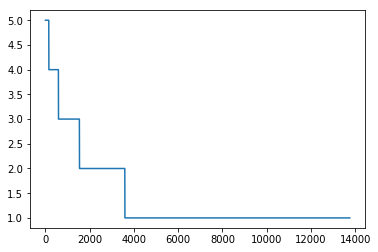

In [9]:
x = np.arange(0, 13758, 1)
y_raw = dataset_3.max(axis = 0).astype('int64').sort_values(ascending = False)
plt.plot(x, y_raw)
plt.show()

Creo tablas con los promedios por artista y por usuario precalculados

In [10]:
r_u = np.zeros((len(dataset_3.index.values), 0))
r_u_p = pd.DataFrame(r_u, index = list(dataset_3.index.values))
r_u_p['PROMEDIO'] = 0

r_i = np.zeros((len(dataset_3['VALOR'].columns.values), 0))
r_i_p = pd.DataFrame(r_i, index = list(dataset_3['VALOR'].columns.values))
r_i_p['PROMEDIO'] = 0

for i in r_u_p.index.values:
    r_u_p.loc[i] = dataset_3.loc[i].mean()

for i in r_i_p.index.values:
    r_i_p.loc[i] = dataset_3[('VALOR', i)].mean()

r_u_p.to_pickle('r_u_p.pickle')
r_i_p.to_pickle('r_i_p.pickle')

Creo la semejanza de coseno ajustada, Pearson y Jaccard para el modelo usuario-usuario e item-item:

In [11]:
#dataset_3 = pd.read_pickle('matriz_limpia_y_estandarizada.pickle')

def calc_coseno(df, it1, it2):
    p1 = 0
    p2 = 0
    p3 = 0
    for i in df.index:
        valor_1 = df[('VALOR', it1)].loc[i]
        valor_2 = df[('VALOR', it2)].loc[i]
        r_u_p_i = r_u_p['PROMEDIO'].loc[i]
        p1 += (valor_1 - r_u_p_i) * (valor_2 - r_u_p_i)
        p2 += (valor_1 - r_u_p_i) ** 2
        p3 += (valor_2 - r_u_p_i) ** 2
    p2 = p2 ** 0.5
    p3 = p3 ** 0.5
    return (p1 / (p2 * p3))

def calc_pearson(df, it1, it2):
    p1 = 0
    p2 = 0
    p3 = 0
    for i in df.index:
        valor_1 = df[('VALOR', it1)].loc[i]
        valor_2 = df[('VALOR', it2)].loc[i]
        r_i_p_i = r_i_p['PROMEDIO'].loc[it1]
        r_i_p_j = r_i_p['PROMEDIO'].loc[it2]
        p1 += (valor_1 - r_i_p_i) * (valor_2 - r_i_p_j)
        p2 += (valor_1 - r_i_p_i) ** 2
        p3 += (valor_2 - r_i_p_j) ** 2
    p2 = p2 ** 0.5
    p3 = p3 ** 0.5
    return (p1 / (p2 * p3))

def calc_jaccard(df, it1, it2):
    int = 0
    uni = 0
    for i in df.index:
        valor_1 = df[('VALOR', it1)].loc[i]
        valor_2 = df[('VALOR', it2)].loc[i]
        if valor_1 > 0 and valor_2 > 0:
            int += 1
        if valor_1 > 0 or valor_2 > 0:
            uni += 1
    return int / uni

print(calc_coseno(dataset_3, 'Megadeth', 'Metallica'))
print(calc_pearson(dataset_3, 'Megadeth', 'Metallica'))
print(calc_jaccard(dataset_3, 'Megadeth', 'Metallica'))

0.5985068325663064
0.551751543667303
0.3619047619047619


In [50]:
print(dataset_3)

            VALOR                                          \
ARTIST_NAME   !!! $Wingin' Utter$ 'Til Tuesday (Həd) P.E.   
USERID                                                      
user_000001     0               0            0          0   
user_000002     0               1            0          0   
user_000003     0               0            0          0   
user_000004     1               0            0          0   
user_000005     0               0            0          0   
user_000006     0               0            0          0   
user_000007     0               0            0          0   
user_000008     0               0            0          0   
user_000009     0               0            0          0   
user_000010     0               0            0          0   
user_000011     0               0            0          1   
user_000012     1               0            0          0   
user_000013     0               0            0          0   
user_000014     0       

Ahora convierto el dataset a un dataset de surprise.

In [97]:

t1 = time.clock()

surprise_df = pd.DataFrame(columns=['user', 'artist', 'rating'])
k = 1
print('Total artistas: ' + str(dataset_3.columns.size))
kk = 0
for i in dataset_3.columns:
    if k%5 is 0:
        print('Procesando artista no. ' + str(k))
        # todo remove this. doing this to only iterate through 4 artists
        break
    for j in enumerate(dataset_3[i]):
        if (dataset_3[i][j[0]] > 0):
            surprise_df.loc[kk] = [j[0], i[1], int(dataset_3[i][j[0]])]
            kk = kk + 1
    k = k + 1
print(surprise_df)
data = Dataset.load_from_df(surprise_df, Reader())
trainingSet = data.build_full_trainset()

sim_options = {
    'name': 'cosine',
    'user_based': False
}

knn = KNNBasic(sim_options=sim_options)
knn.train(trainingSet)

t2 = time.clock()

Total artistas: 13758
Procesando artista no. 5
    user      artist rating
0      3         !!!      1
1     11         !!!      1
2     23         !!!      1
3     29         !!!      1
4     30         !!!      1
5     33         !!!      1
6     35         !!!      1
7     39         !!!      1
8     42         !!!      1
9     49         !!!      1
10    59         !!!      1
11    61         !!!      1
12    66         !!!      1
13    80         !!!      1
14    85         !!!      1
15    89         !!!      1
16    90         !!!      1
17    92         !!!      1
18    94         !!!      1
19   111         !!!      1
20   115         !!!      1
21   119         !!!      1
22   130         !!!      1
23   131         !!!      1
24   132         !!!      1
25   133         !!!      1
26   134         !!!      1
27   135         !!!      1
28   142         !!!      1
29   146         !!!      1
..   ...         ...    ...
283  115  (Həd) P.E.      1
284  127  (Həd) P.E.      1
2

In [51]:
ratings_dict = {'itemID': [1, 1, 1, 2, 2],
                'userID': [9, 32, 2, 45, 'user_foo'],
                'rating': [3, 2, 4, 3, 1]}
df = pd.DataFrame(ratings_dict)
print(df)

   itemID  rating    userID
0       1       3         9
1       1       2        32
2       1       4         2
3       2       3        45
4       2       1  user_foo


In [295]:
columnas = dataset_3['VALOR'].columns.values
tamano = len(dataset_3['VALOR'].columns.values)
x = np.zeros((tamano, tamano))
matriz_item_pearson = pd.DataFrame(x, columns = columnas)
matriz_item_pearson.index = columnas

In [296]:
y = np.zeros((tamano, tamano))
matriz_item_jaccard = pd.DataFrame(y, columns = columnas)
matriz_item_jaccard.index = columnas

In [297]:
z = np.zeros((tamano, tamano))
matriz_item_coseno = pd.DataFrame(z, columns = columnas)
matriz_item_coseno.index = columnas

In [300]:
for i in list(matriz_item_pearson.index.values):
    for j in list(matriz_item_pearson.index.values):
        if matriz_item_pearson[i][j] == 0:
            prsn = calc_pearson(dataset_3, i, j)
            matriz_item_pearson[i][j] = prsn
            matriz_item_pearson[j][i] = prsn

matriz_item_pearson.to_pickle('matriz_item_pearson.pickle')

for i in list(matriz_item_jaccard.index.values):
    for j in list(matriz_item_jaccard.index.values):
        if matriz_item_jaccard[i][j] == 0:
            jcrd = calc_jaccard(dataset_3, i, j)
            matriz_item_jaccard[i][j] = jcrd
            matriz_item_jaccard[j][i] = jcrd

matriz_item_jaccard.to_pickle('matriz_item_jaccard.pickle')

for i in list(matriz_item_coseno.index.values):
    for j in list(matriz_item_coseno.index.values):
        if matriz_item_coseno[i][j] == 0:
            csn = calc_coseno(dataset_3, i, j)
            matriz_item_coseno[i][j] = csn
            matriz_item_coseno[j][i] = csn

matriz_item_coseno.to_pickle('matriz_item_coseno.pickle')

KeyboardInterrupt: 

In [349]:
dataset_4 = dataset_3.stack()
dataset_4.reset_index(level = [0, 1], inplace = True)